In [2]:
import warnings

warnings.filterwarnings("ignore")
import math
import numpy as np
import paddle
from paddle import nn

In [4]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)

# 噪声
labels += np.random.normal(scale=0.1, size=labels.shape)

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [paddle.to_tensor(x, dtype=
    paddle.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(Tensor(shape=[2, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
        [[ 0.06114778],
         [-0.71380317]]),
 Tensor(shape=[2, 20], dtype=float32, place=Place(gpu:0), stop_gradient=True,
        [[ 1.        ,  0.06114778,  0.00186953,  0.00003811,  0.00000058,
           0.00000001,  0.00000000,  0.00000000,  0.00000000,  0.00000000,
           0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000,
           0.00000000,  0.00000000,  0.00000000,  0.00000000,  0.00000000],
         [ 1.        , -0.71380317,  0.25475746, -0.06061556,  0.01081689,
          -0.00154423,  0.00018371, -0.00001873,  0.00000167, -0.00000013,
           0.00000001, -0.00000000,  0.00000000, -0.00000000,  0.00000000,
          -0.00000000,  0.00000000, -0.00000000,  0.00000000, -0.00000000]]),
 Tensor(shape=[2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
        [4.88170099, 2.93184662]))

In [10]:
from LinerRegression.picCatTrainFromZeroUtils import train_epoch_ch3
from utils import evaluate_loss, load_array
from LinerRegression.Animator import Animator


def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias_attr=False))
    batch_size = min(10, train_labels.shape[0])
    print(batch_size)
    train_iter = load_array(((train_features, train_labels.reshape([-1,1]))),
                                batch_size)
    test_iter = load_array((test_features, test_labels.reshape([-1,1])),
                               batch_size, is_train=False)
    trainer = paddle.optimizer.SGD(parameters=net.parameters(), learning_rate=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.numpy())

weight: [[ 4.9999075]
 [ 1.226889 ]
 [-3.3861437]
 [ 5.5852356]]


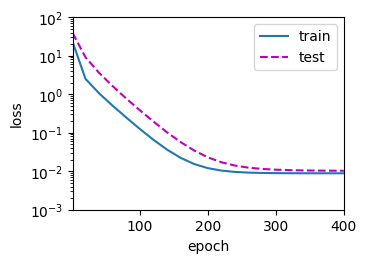

In [11]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.5984552]
 [3.3785276]]


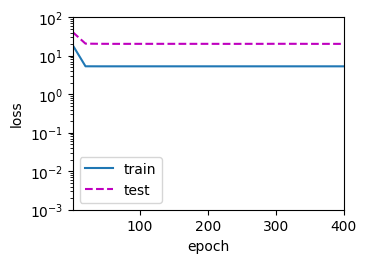

In [12]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0010271e+00]
 [ 1.2663281e+00]
 [-3.3666940e+00]
 [ 5.3496699e+00]
 [-8.9019105e-02]
 [ 7.6269585e-01]
 [-2.4008566e-01]
 [-5.1192116e-02]
 [-3.4851655e-01]
 [-1.9895406e-02]
 [-4.7794768e-01]
 [ 2.2256662e-01]
 [ 4.6430206e-01]
 [ 3.4228590e-01]
 [ 5.3543381e-02]
 [-1.8788493e-01]
 [ 4.3487811e-01]
 [-3.4404159e-01]
 [ 4.6801851e-03]
 [ 2.8962487e-01]]


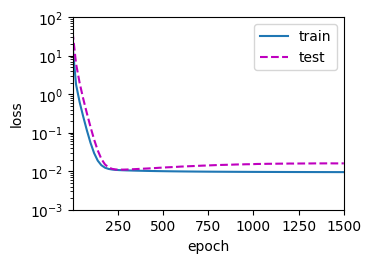

In [13]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)